DiGraph with 4 nodes and 3 edges
{}
[('Se_0', None), ('1_1', None), ('C_2', None), ('I_3', None)]


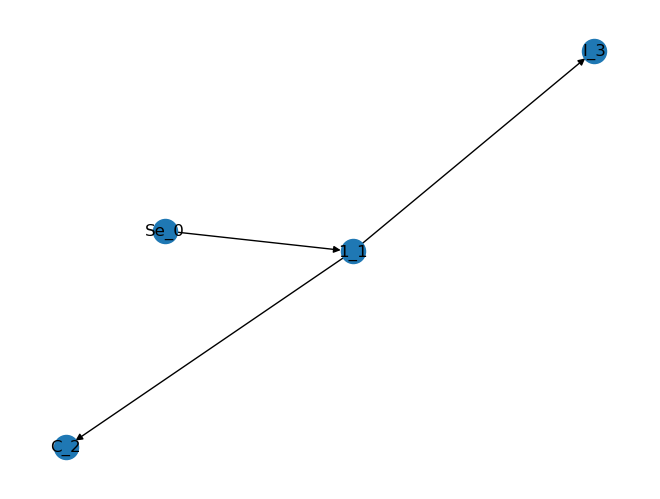

In [28]:
import networkx as nx
from bond_graph import *

class TestNode():
    def __init__(self, port_type, param):
        self.port_type = port_type
        self.param = param
    def add_port():
        return 0

G = BondGraph()
G.add_port(EffortSource())
G.add_port(OneJunction())
G.add_bond('Se_0', '1_1', imposed_causality=GeneralizedVariables.EFFORT)
G.add_port(Capacitance(1))
G.add_bond('1_1', 'C_2', imposed_causality=GeneralizedVariables.FLOW)
G.add_port(Inertance(10))
G.add_bond('1_1', 'I_3', imposed_causality=GeneralizedVariables.FLOW)
print(G.graph)
print(G.graph.graph)

# print(G.graph.nodes['1_1'])

print(list(G.graph.nodes(data=true)))
nx.draw(G.graph, with_labels=True)


In [ ]:
from sympy import *

params = {"x":1, "y":2}
vars = symbols(list(params.keys()))

print(y)
# for key, value in enumerate(params):
#     vars[key] = params[key]


In [15]:

import itertools
from itertools import permutations 

max_nodes = 3
possible_edge_list = permutations(range(max_nodes), 2)

print(list(possible_edge_list))

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


In [31]:
import networkx as nx
G = nx.DiGraph()
G.add_node(1, x={'a':1, 'b':2})
G.add_node(2)
G.add_node(3, bond_type='causal')
G.nodes.data()

NodeDataView({1: {'x': {'a': 1, 'b': 2}}, 2: {}, 3: {'bond_type': 'causal'}})